In [11]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.utils.data
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [92]:
# load all data
data = pd.read_csv('SFEW.csv',  header=None, skiprows=1)

# drop first column
data.drop(data.columns[0], axis=1, inplace=True)
data.drop([205], axis=0, inplace=True) #remove Nan PHOG descriptor pattern

# try shuffle data
data = data.sample(frac=1).reset_index(drop=True)

#preprocessing????
for column in data:
    if column == 1:
        pass
    else:
        data[column] = data.loc[:, [column]].apply(lambda x: (x - x.mean()) / x.std())
        
# stratified split into training set (50%) and testing set (50%)
X = data.iloc[:,1:11].values
Y = data.iloc[:,0].values-1
x1, x2, y1, y2 = train_test_split(X, Y, train_size=0.5, random_state=42, stratify=Y)

In [93]:
def data_prep(x1,x2,y1,y2):
    train_x, train_y = torch.Tensor(x1), torch.Tensor(y1).long()
    test_x, test_y = torch.Tensor(x2), torch.Tensor(y2).long()
    train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    return list([train_x, train_y, test_x, test_y, train_loader])

data1 = data_prep(x1,x2,y1,y2)
data2 = data_prep(x2,x1,y2,y1)

In [5]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        first = self.fc1(x)
        act = self.sigmoid(first)
        out = self.fc2(act)
        return act, out
    
criterion = nn.CrossEntropyLoss()
lr = 0.0001

In [6]:
# define a function to plot confusion matrix
def plot_confusion(input_sample, num_classes, des_output, actual_output):
    confusion = torch.zeros(num_classes, num_classes)
    for i in range(input_sample):
        actual_class = actual_output[i]
        predicted_class = des_output[i]

        confusion[actual_class][predicted_class] += 1

    return confusion

In [7]:
def train_step(model, optimizer, loader):
    for step, (batch_x, batch_y) in enumerate(loader):
        X = batch_x
        Y = batch_y.long()
        _, outputs = model(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        return loss.item()
        
def prune_one(model, x):
    n_neu = model.fc1.weight.data.size(0)
    activation, _ = model(x)
    cos = nn.CosineSimilarity(dim=0, eps=1e-6)
    activation += torch.full(activation.size(), -0.5)
    for j in range(n_neu):
        for k in range(j+1,n_neu):
            angle = cos(activation[:,j],activation[:,k])
            n_neu = net.fc1.weight.data.size(0)
            if angle.item() >= 0.965926:
                model.fc1.weight.data[j] += model.fc1.weight.data[k]
                model.fc1.bias.data[j] += model.fc1.bias.data[k]
                
                keep = list(range(n_neu))
                keep.pop(k)

                model.fc1.weight.data = model.fc1.weight.data[keep]
                model.fc2.weight.data = model.fc2.weight.data[:, keep]
                model.fc1.bias.data = model.fc1.bias.data[keep]

            if angle.item() <= -0.965926:
                keep = list(range(n_neu))
                keep.pop(k)
                keep.pop(j)

                model.fc1.weight.data = model.fc1.weight.data[keep]
                model.fc2.weight.data = model.fc2.weight.data[:, keep]
                model.fc1.bias.data = model.fc1.bias.data[keep]
            
            if net.fc1.weight.data.size(0) < n_neu:
                break
                
        if net.fc1.weight.data.size(0) < n_neu:
                break
    return model

def prune_many(model, x):
    n_neu = model.fc1.weight.data.size(0)
    activation, _ = model(x)
    cos = nn.CosineSimilarity(dim=0, eps=1e-6)
    activation += torch.full(activation.size(), -0.5)
    keep = list(range(n_neu))
    for j in range(n_neu):
        for k in range(j+1,n_neu):
            angle = cos(activation[:,j],activation[:,k])
            n_neu = net.fc1.weight.data.size(0)
            if angle.item() >= 0.965926 and k in keep:
                model.fc1.weight.data[j] += model.fc1.weight.data[k]
                model.fc1.bias.data[j] += model.fc1.bias.data[k]
                keep.remove(k)
            if angle.item() <= -0.965926 and k in keep and j in keep:
                keep.remove(k)
                keep.remove(j)
    model.fc1.weight.data = model.fc1.weight.data[keep]
    model.fc2.weight.data = model.fc2.weight.data[:, keep]
    model.fc1.bias.data = model.fc1.bias.data[keep]
    return model

In [8]:
def accuracy(model, X, Y):
    _, outputs = net(X)
    _, predicted = torch.max(outputs, 1)
    total = predicted.size(0)
    correct = sum(predicted.data.numpy() == Y.data.numpy())
    return 100*correct/total

In [64]:
def plot_prs(inputs, num_classes, targets, outputs):
    confusion = plot_confusion(inputs, num_classes, targets, outputs)
    prs = torch.zeros(3, num_classes)
    
    def div(n, d):
        if d == 0:
            return 0
        else:
            return n / d
    
    for i in range(num_classes):
        tp = confusion[i,i].item()
        fp = (sum(confusion[:,i])-confusion[i,i]).item()
        fn = (sum(confusion[i,:])-confusion[i,i]).item()
        tn = targets.size(0)-tp-fp-fn
        
        prs[:,i] = torch.Tensor([div(tp,tp+fp),div(tp,tp+fn),div(tn,tn+fp)])
    return prs

#print(plot_prs(test_LPQ_x.shape[0], 7, predicted.long().data, test_y.data))

In [100]:
net = Net(10,1000,7)
optimizer = torch.optim.Adam(net.parameters(), 0.01)

num_epochs = 1000

for epoch in range(num_epochs):
    train_step(net, optimizer, data1[4])
    if epoch % 100 == 0:
        print('Training Accuracy: %.2f %%' % accuracy(net, data1[0], data1[1]))
        print('Testing Accuracy: %.2f %%' % accuracy(net, data1[2], data1[3]))
        
        #pruning
        net = prune_one(net, data1[0])
        print('neurons: ',net.fc1.weight.data.size(0))
        optimizer = torch.optim.Adam(net.parameters(), 0.0001)
        
print('Final Training Accuracy: %.2f %%' % accuracy(net, data1[0], data1[1]))
print('Final Testing Accuracy: %.2f %%' % accuracy(net, data1[2], data1[3]))

Training Accuracy: 15.43 %
Testing Accuracy: 14.54 %
57
neurons:  999
Training Accuracy: 19.88 %
Testing Accuracy: 17.21 %
neurons:  997
Training Accuracy: 20.18 %
Testing Accuracy: 20.18 %
neurons:  995
Training Accuracy: 22.55 %
Testing Accuracy: 21.07 %
neurons:  995
Training Accuracy: 22.26 %
Testing Accuracy: 19.88 %
neurons:  995
Training Accuracy: 24.33 %
Testing Accuracy: 21.66 %
neurons:  995
Training Accuracy: 24.93 %
Testing Accuracy: 21.66 %
neurons:  995
Training Accuracy: 25.22 %
Testing Accuracy: 22.85 %
596
neurons:  994
Training Accuracy: 23.15 %
Testing Accuracy: 25.22 %
neurons:  994
Training Accuracy: 24.63 %
Testing Accuracy: 26.11 %
neurons:  994
Final Training Accuracy: 24.33 %
Final Testing Accuracy: 22.85 %


In [77]:
net = Net(10,1000,7)
optimizer = torch.optim.Adam(net.parameters(), 0.01)

num_epochs = 1000

for epoch in range(num_epochs):
    train_step(net, optimizer, data1[4])
    if epoch % 100 == 0:
        print('Training Accuracy: %.2f %%' % accuracy(net, data1[0], data1[1]))
        print('Testing Accuracy: %.2f %%' % accuracy(net, data1[2], data1[3]))
        
#pruning
net = prune_many(net, data1[0])
print('neurons: ',net.fc1.weight.data.size(0))
print('Final Training Accuracy: %.2f %%' % accuracy(net, data1[0], data1[1]))
print('Final Testing Accuracy: %.2f %%' % accuracy(net, data1[2], data1[3]))

Training Accuracy: 15.08 %
Testing Accuracy: 14.24 %
Training Accuracy: 23.74 %
Testing Accuracy: 16.46 %
Training Accuracy: 26.26 %
Testing Accuracy: 13.92 %
Training Accuracy: 32.40 %
Testing Accuracy: 17.09 %
Training Accuracy: 32.40 %
Testing Accuracy: 18.67 %
Training Accuracy: 37.71 %
Testing Accuracy: 20.25 %
Training Accuracy: 54.75 %
Testing Accuracy: 22.15 %
Training Accuracy: 61.73 %
Testing Accuracy: 20.89 %
Training Accuracy: 67.60 %
Testing Accuracy: 18.99 %
Training Accuracy: 74.86 %
Testing Accuracy: 21.84 %
neurons:  510
Final Training Accuracy: 63.69 %
Final Testing Accuracy: 17.09 %


In [102]:
net = Net(10,1000,7)
optimizer = torch.optim.Adam(net.parameters(), 0.01)

num_epochs = 1000

for epoch in range(num_epochs):
    train_step(net, optimizer, data1[4])
    if epoch % 200 == 0:
        print('Training Accuracy: %.2f %%' % accuracy(net, data1[0], data1[1]))
        print('Testing Accuracy: %.2f %%' % accuracy(net, data1[2], data1[3]))
        
        #pruning
        prune_many(net, data1[0])
        print('neurons: ',net.fc1.weight.data.size(0))
        optimizer = torch.optim.Adam(net.parameters(), 0.0001)

Training Accuracy: 13.95 %
Testing Accuracy: 14.84 %
neurons:  999
Training Accuracy: 23.74 %
Testing Accuracy: 21.07 %
neurons:  999
Training Accuracy: 23.74 %
Testing Accuracy: 23.15 %
neurons:  999
Training Accuracy: 24.04 %
Testing Accuracy: 23.74 %
neurons:  999
Training Accuracy: 27.89 %
Testing Accuracy: 23.44 %
neurons:  999


In [107]:
net = Net(10,40,7)
optimizer = torch.optim.Adam(net.parameters(), 0.01)

num_epochs = 1000

for epoch in range(num_epochs):
    train_step(net, optimizer, data1[4])
    if epoch % 200 == 0:
        print('Training Accuracy: %.2f %%' % accuracy(net, data1[0], data1[1]))
        print('Testing Accuracy: %.2f %%' % accuracy(net, data1[2], data1[3]))
        
        #pruning
        prune_many(net, data1[0])
        print('neurons: ',net.fc1.weight.data.size(0))
        optimizer = torch.optim.Adam(net.parameters(), 0.0001)

Training Accuracy: 14.84 %
Testing Accuracy: 14.84 %
neurons:  40
Training Accuracy: 14.84 %
Testing Accuracy: 14.84 %
neurons:  40
Training Accuracy: 12.46 %
Testing Accuracy: 15.13 %
neurons:  40
Training Accuracy: 16.62 %
Testing Accuracy: 17.80 %
neurons:  40
Training Accuracy: 17.21 %
Testing Accuracy: 20.77 %
neurons:  40


In [16]:
net = Net(10, 1000, 7)
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

num_epochs = 1000

for epoch in range(num_epochs):
    train_step(net, optimizer, data1[4])
    if epoch % 200 == 0:
        print('Training Accuracy: %.2f %%' % accuracy(net, data1[0], data1[1]))
        print('Testing Accuracy: %.2f %%' % accuracy(net, data1[2], data1[3]))

Training Accuracy: 11.45 %
Testing Accuracy: 13.61 %
Training Accuracy: 24.86 %
Testing Accuracy: 16.46 %
Training Accuracy: 29.61 %
Testing Accuracy: 18.04 %
Training Accuracy: 25.98 %
Testing Accuracy: 17.41 %
Training Accuracy: 30.17 %
Testing Accuracy: 17.72 %


Training Accuracy: 29.89 %
Testing Accuracy: 17.41 %


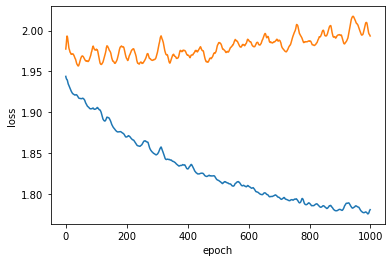

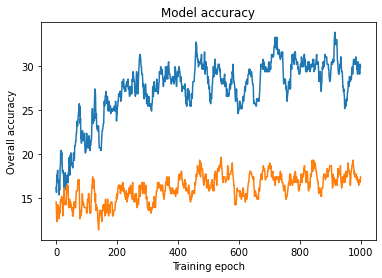

In [17]:
net = Net(10, 1000, 7)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

train_loss = []
test_loss = []

train_acc = []
test_acc = []

num_epochs = 1000

# train the model by batch
for epoch in range(num_epochs):
    train_step(net, optimizer, data1[4])
    _, train_out = net(data1[0])
    _, test_out = net(data1[2])
    train_loss.append(criterion(train_out , data1[1]))
    test_loss.append(criterion(test_out, data1[3]))
    train_acc.append(accuracy(net, data1[0], data1[1]))
    test_acc.append(accuracy(net, data1[2], data1[3]))
    
print('Training Accuracy: %.2f %%' % accuracy(net, data1[0], data1[1]))
print('Testing Accuracy: %.2f %%' % accuracy(net, data1[2], data1[3]))

#
plt.figure()
plt.plot(train_loss, label="training")
plt.plot(test_loss, label="testing")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

plt.figure()
plt.title('Model accuracy')
plt.plot(train_acc, label="training")
plt.plot(test_acc, label="testing")
plt.xlabel('Training epoch')
plt.ylabel('Overall accuracy')
plt.show()

In [69]:
def normal_NN(num_epoch, num_hidden, lr, x):
    if x == 1:
        data = data1
    if x == 2:
        data = data2
        
    net = Net(10, num_hidden, 7)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    train_acc = []
    test_acc = []

    for epoch in range(num_epoch):
        train_step(net, optimizer, data[4])
        _, train_out = net(data[0])
        _, test_out = net(data[2])
        train_acc.append(accuracy2(train_out, data[1]))
        test_acc.append(accuracy2(test_out, data[3]))
    
    print('neurons:', num_hidden,', lr: ', lr)
    print('Training Accuracy: %.2f %%' % accuracy2(train_out, data[1]))
    print('Testing Accuracy: %.2f %%' % accuracy2(test_out, data[3]))

    plt.figure()
    plt.plot(train_acc, label="training")
    plt.plot(test_acc, label="testing")
    plt.xlabel('Training epoch')
    plt.ylabel('Overall Accuracy (%)')
    plt.show()
    
    _, predicted = torch.max(test_out, 1)
    print(plot_prs(data[2].shape[0], 7, predicted.long().data, data[3].data))

neurons: 10 , lr:  0.0001
Training Accuracy: 16.76 %
Testing Accuracy: 11.71 %


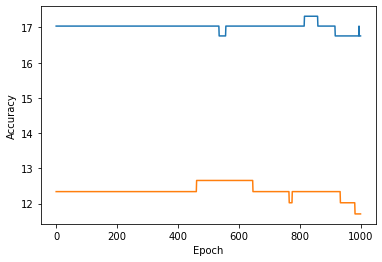

neurons: 100 , lr:  0.0001
Training Accuracy: 24.30 %
Testing Accuracy: 14.87 %


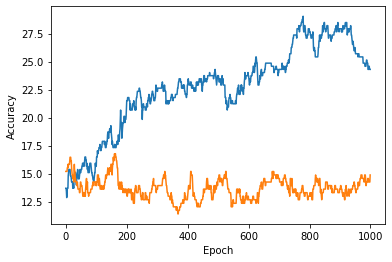

neurons: 1000 , lr:  0.0001
Training Accuracy: 29.33 %
Testing Accuracy: 17.41 %


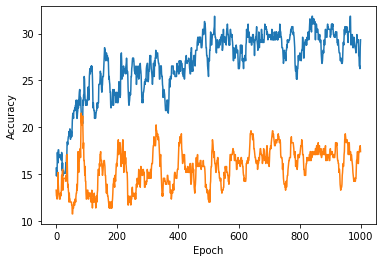

neurons: 10 , lr:  0.001
Training Accuracy: 27.65 %
Testing Accuracy: 17.09 %


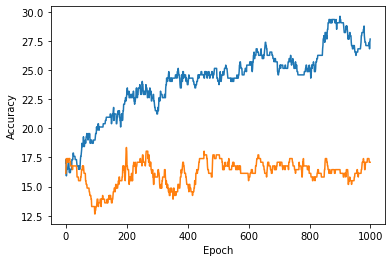

neurons: 100 , lr:  0.001
Training Accuracy: 32.96 %
Testing Accuracy: 17.41 %


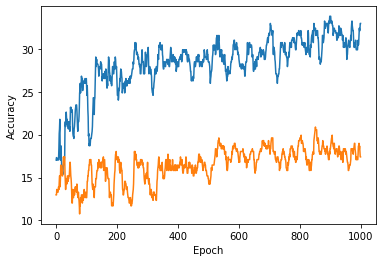

neurons: 1000 , lr:  0.001
Training Accuracy: 31.01 %
Testing Accuracy: 20.25 %


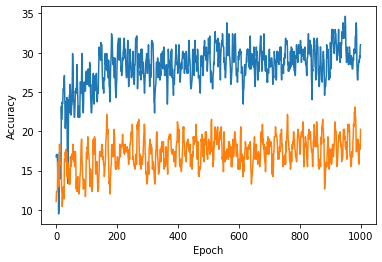

In [38]:
normal_NN(2000,10,0.0001,1)
normal_NN(2000,100,0.0001,1)
normal_NN(2000,1000,0.0001,1)
normal_NN(2000,10,0.001,1)
normal_NN(2000,100,0.001,1)
normal_NN(2000,1000,0.001,1)

In [36]:
def accuracy2(outputs, target):
    _, predicted = torch.max(outputs, 1)
    total = predicted.size(0)
    correct = sum(predicted.data.numpy() == target.data.numpy())
    return 100*correct/total

neurons: 10 , lr:  0.01
Training Accuracy: 44.41 %
Testing Accuracy: 19.62 %


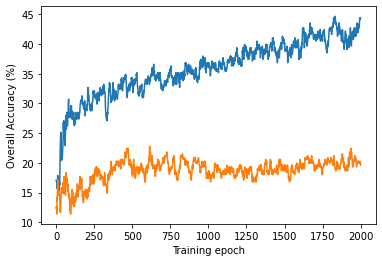

neurons: 100 , lr:  0.01
Training Accuracy: 99.16 %
Testing Accuracy: 19.94 %


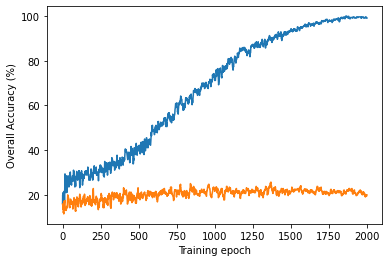

neurons: 1000 , lr:  0.01
Training Accuracy: 100.00 %
Testing Accuracy: 21.52 %


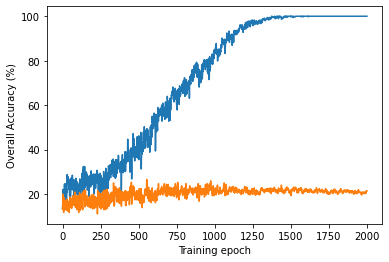

In [45]:
normal_NN(2000,10,0.01,1)
normal_NN(2000,100,0.01,1)
normal_NN(2000,1000,0.01,1)

neurons: 10 , lr:  0.01
Training Accuracy: 39.87 %
Testing Accuracy: 22.63 %


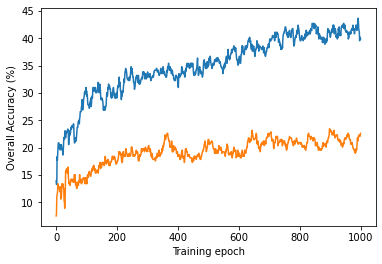

neurons: 100 , lr:  0.01
Training Accuracy: 74.05 %
Testing Accuracy: 22.63 %


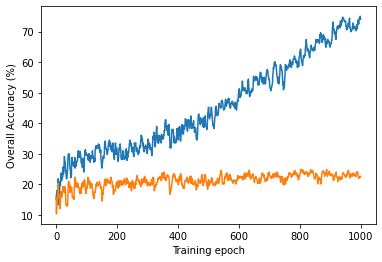

neurons: 1000 , lr:  0.01
Training Accuracy: 90.51 %
Testing Accuracy: 22.63 %


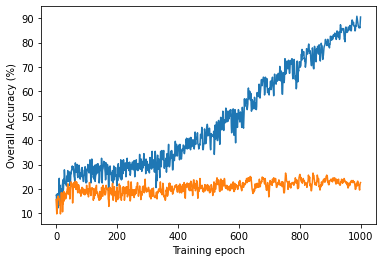

In [49]:
normal_NN(1000,10,0.01,2)
normal_NN(1000,100,0.01,2)
normal_NN(1000,1000,0.01,2)

neurons: 1000 , lr:  0.01
Training Accuracy: 89.87 %
Testing Accuracy: 23.74 %


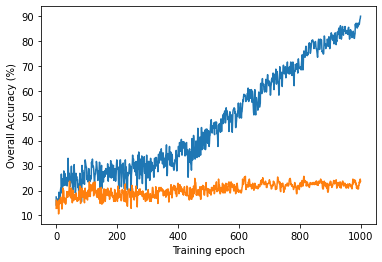

neurons: 1000 , lr:  0.01
Training Accuracy: 85.47 %
Testing Accuracy: 20.89 %


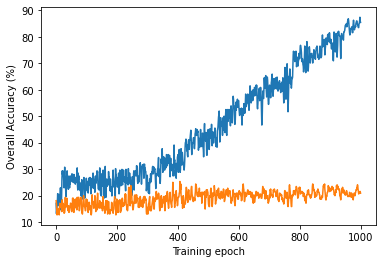

In [50]:
normal_NN(1000,1000,0.01,2)
normal_NN(1000,1000,0.01,1)

neurons: 2000 , lr:  0.01
Training Accuracy: 87.03 %
Testing Accuracy: 22.35 %


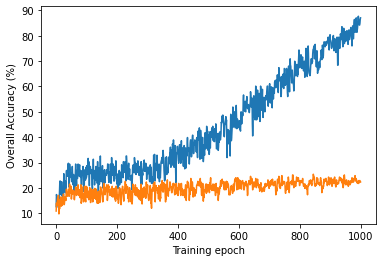

neurons: 2000 , lr:  0.01
Training Accuracy: 84.64 %
Testing Accuracy: 19.94 %


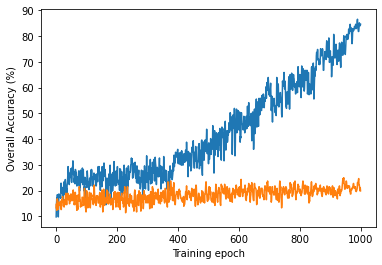

In [54]:
normal_NN(1000,2000,0.01,2)
normal_NN(1000,2000,0.01,1)

neurons: 1000 , lr:  0.01
Training Accuracy: 82.79 %
Testing Accuracy: 26.41 %


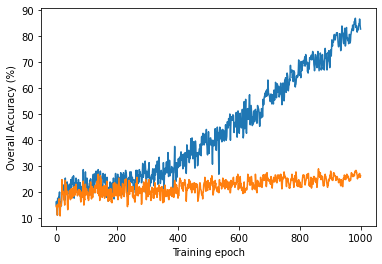

tensor([[0.1905, 0.2449, 0.2754, 0.3086, 0.2273, 0.2286, 0.2895],
        [0.0800, 0.3158, 0.3878, 0.5000, 0.2000, 0.1600, 0.2200],
        [0.9408, 0.8763, 0.8264, 0.8049, 0.8815, 0.9059, 0.9059]])


In [94]:
normal_NN(1000,1000,0.01,1)

neurons: 1000 , lr:  0.01
Training Accuracy: 86.05 %
Testing Accuracy: 25.52 %


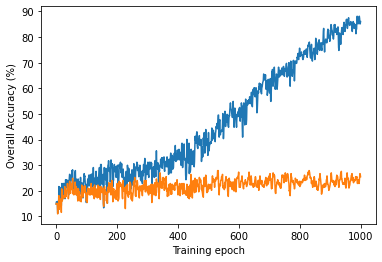

tensor([[0.2292, 0.1538, 0.2917, 0.2949, 0.2128, 0.3077, 0.2105],
        [0.2200, 0.1081, 0.2800, 0.4600, 0.2000, 0.3200, 0.1600],
        [0.8711, 0.9267, 0.8815, 0.8084, 0.8711, 0.8746, 0.8955]])


In [95]:
normal_NN(1000,1000,0.01,2)

neurons: 1000 , lr:  0.01
Training Accuracy: 31.75 %
Testing Accuracy: 19.88 %


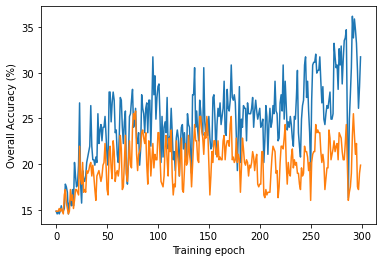

tensor([[0.1818, 0.2500, 0.4000, 0.3171, 0.1929, 0.1458, 0.2143],
        [0.1200, 0.0541, 0.0400, 0.2600, 0.5400, 0.2800, 0.0600],
        [0.9059, 0.9800, 0.9895, 0.9024, 0.6063, 0.7143, 0.9617]])


In [101]:
normal_NN(300,1000,0.01,2)

In [96]:
ave = (torch.Tensor([[0.1905, 0.2449, 0.2754, 0.3086, 0.2273, 0.2286, 0.2895],
        [0.0800, 0.3158, 0.3878, 0.5000, 0.2000, 0.1600, 0.2200],
        [0.9408, 0.8763, 0.8264, 0.8049, 0.8815, 0.9059, 0.9059]])+ torch.Tensor([[0.2292, 0.1538, 0.2917, 0.2949, 0.2128, 0.3077, 0.2105],
        [0.2200, 0.1081, 0.2800, 0.4600, 0.2000, 0.3200, 0.1600],
        [0.8711, 0.9267, 0.8815, 0.8084, 0.8711, 0.8746, 0.8955]]))/2
print(ave)
#average PRS

tensor([[0.2099, 0.1993, 0.2836, 0.3018, 0.2201, 0.2682, 0.2500],
        [0.1500, 0.2120, 0.3339, 0.4800, 0.2000, 0.2400, 0.1900],
        [0.9060, 0.9015, 0.8540, 0.8066, 0.8763, 0.8902, 0.9007]])


In [98]:
print(26.41/2+25.52/2)

25.965
